# Background

`avl_queue.move` structures are as follows (comments removed for brevity):

```rust
struct AVLqueue<V> has store {
    bits: u128,
    root_lsbs: u8,
    tree_nodes: TableWithLength<u64, TreeNode>,
    list_nodes: TableWithLength<u64, ListNode>,
    values: Table<u64, Option<V>>
}
   
struct TreeNode has store {
    bits: u128
}

struct ListNode has store {
    last_msbs: u8,
    last_lsbs: u8,
    next_msbs: u8,
    next_lsbs: u8
}
```

Similarly, `avl_queue_benchmark.move` has:
    
```rust

struct AVLqueueStore has key {
    map: TableWithLength<u64, AVLqueue<Value>>
}

struct Value has store {
    addr: address,
    bits: u128
}
```

Table handles are an `address` type, which is itself 32 bytes, and a `TableWithLength` has a `u64` encoded as well yielding the following byte sizes:

In [1]:
table_with_length_bytes = 32 + int(64 / 8)
table_with_length_bytes

40

In [2]:
avlq_size_bytes = \
    int(128 / 8) \
    + 1 \
    + 2 * table_with_length_bytes \
    + 32
avlq_size_bytes

129

In [3]:
tree_node_size_bytes = int(128 / 8)
tree_node_size_bytes

16

In [4]:
list_node_size_bytes = 4
list_node_size_bytes

4

In [5]:
avlq_store_size_bytes = table_with_length_bytes
avlq_store_size_bytes

40

In [6]:
value_size_bytes = 32 + int(128 / 8)
value_size_bytes

48

As of the time of this writing, [external storage gas costs](https://aptos.dev/concepts/base-gas/#optimization-principles) are as follows:

In [7]:
sf = 10_000 # Scaling factor.
per_item_read = 300_000 / sf
per_item_create = 5_000_000 / sf
per_item_write = 300_000 / sf
per_byte_read = 300 / sf
per_byte_create = 5000 / sf
per_byte_write = 5000 / sf

As of the time of this writing, gas prices are at 100, there are 10^8 octas per APT, and 1 APT costs $8.8 USD:

In [8]:
octas_per_gas = 100
octas_per_apt = 10 ** 8
usd_per_apt = 8.8
usd_per_gas = octas_per_gas / octas_per_apt * usd_per_apt

# Helper functions 

In [9]:
import pandas as pd
import time

from aptos_sdk.account import Account
from aptos_sdk.bcs import Serializer
from aptos_sdk.client import RestClient, FaucetClient
from aptos_sdk.transactions import (
    EntryFunction,
    ModuleId,
    TransactionArgument as TxArg,
    TransactionPayload as TxPayload)
from aptos_sdk.type_tag import StructTag
from IPython.display import clear_output
from typing import Any, Dict
from pathlib import Path

Getting account via keyfile:

In [10]:
# Relative path to hot keyfile for testing only.
# File should contain hex key only.
key_file = sorted(Path('../../.secrets').glob('*.key'))[0]
with open(key_file) as f: # Open file.
    key = f.readline().rstrip() # Get key.
# Get account from key.
account = Account.load_key(key)
# Print account address in hex.
account.address().hex()

'0x7c492623d3dd9fc19fa93a20a0e92c2c634a72a1e28392cb6509e22aeb7333c9'

REST client:

In [11]:
# Declare base URL for devnet REST API.
client_url = 'https://fullnode.devnet.aptoslabs.com/v1'
# Declare base URL for faucet.
faucet_url = 'https://faucet.devnet.aptoslabs.com'
# Explorer base URL.
explorer = 'https://aptos-explorer.netlify.app'
# Explorer network query string.
network_query_string = '?network=devnet'
# Initialize client.
client = RestClient(client_url)
# Initialize faucet.
faucet = FaucetClient(faucet_url, client)
# Get account balance
client.account_balance(account.address())

'170000100'

In [12]:
# Fund from the faucet
faucet.fund_account(account.address().hex(), 1000000000)

In [13]:
# Get account balance
client.account_balance(account.address())

'270000100'

In [14]:
def execute(function: str, args: list) -> str:
    """Call entry function with args, returning tx hash
    
    args should be of format
    [[4, Serializer.u64], [2, Serializer.u128]]
    """
    # Construct entry function payload.
    payload = EntryFunction.natural(
        str(module_id),
        function,
        [],
        [TxArg(a[0], a[1]) for a in args])
    # Generate a signed transaction from the payload.
    signed_tx = client.create_single_signer_bcs_transaction(
        account, TxPayload(payload))
    # Submit signed transaction, returning transaction ID.
    return client.submit_bcs_transaction(signed_tx)

In [15]:
def get_tx_json(hash: str) -> Dict[str, Any]:
    """Query a transaction by hash, returning JSON data"""
    while(True):
        response = client.client.get(
            f'{client.base_url}/transactions/by_hash/{hash}')
        # Assert successful response.
        assert response.status_code == 200, hash
        # If transaction has cleared as user tx:
        if response.json()['type'] == 'user_transaction':
            # Return its JSON data.
            return response.json()
        # Otherwise try again, after waiting.
        time.sleep(0.5) # Else you might get rate-limited.

In [16]:
def print_tx_url(version: str):
    """Print URL to transaction view on explorer"""
    print(f'{explorer}/txn/{version}{network_query_string}')

In [17]:
def gas_diagnostics(tx_json: Dict[str, Any]):
    """Print gas used or link to failed tx"""
    if tx_json['success'] == True:
        gas_used = int(tx_json["gas_used"])
        usd_cost = gas_used * usd_per_gas
        print(f'Gas: {gas_used}, USD: ${usd_cost:1.3}')
    else:
        print_tx_url(tx_json['version'])

# AVL queue interface 

In [18]:
# Declare module name.
module = 'avl_queue_benchmark'
# Get module ID.
module_id = ModuleId(account.address(), module)
# Get AVL queue store struct tag.
struct_tag = StructTag(account.address(),
                       module,
                      'AVLqueueStore',
                       [])
# Check that account has one.
client.account_resource(account.address(),
                        struct_tag.__str__())

{'type': '0x7c492623d3dd9fc19fa93a20a0e92c2c634a72a1e28392cb6509e22aeb7333c9::avl_queue_benchmark::AVLqueueStore',
 'data': {'map': {'inner': {'handle': '0x81999289bc2dffcf77f7dbd1c71c03391b4807a44d06dae9be90f69c1cb1ab1'},
   'length': '6'}}}

In [19]:
def insert(key: int,
           bits: int,
           access_key_expected: int) -> str:
    """Insert given key, returning tx ID"""
    return execute('insert', [
        [key, Serializer.u64],
        [bits, Serializer.u128],
        [access_key_expected, Serializer.u64]
    ])

In [20]:
def insert_evict_tail(
    key: int,
    bits: int,
    access_key_expected: int,
    evictee_access_key_expected: int,
    evictee_value_bits_expected: int) -> str:
    """Insert and evict tail, returning tx ID"""
    return execute('insert_evict_tail', [
        [key, Serializer.u64],
        [bits, Serializer.u128],
        [access_key_expected, Serializer.u64],
        [evictee_access_key_expected, Serializer.u64],
        [evictee_value_bits_expected, Serializer.u128]
    ])

In [21]:
def remove(access_key: int,
           bits_expected: int) -> str:
    """Insert given key, returning tx ID"""
    return execute('remove', [
        [access_key, Serializer.u64],
        [bits_expected, Serializer.u128]
    ])

In [22]:
def clear() -> str:
    """Clear AVL queue, returning tx ID"""
    return execute('clear', [])

In [23]:
def reset(n_inactive_tree_nodes: int = 0,
          n_inactive_list_nodes: int = 0) -> str:
    """Reset AVL queue, returning tx ID"""
    return execute('reset', [
        [n_inactive_tree_nodes, Serializer.u64],
        [n_inactive_list_nodes, Serializer.u64],
    ])

In [24]:
# Set at bits 0-31
HI_32 = int('1'* 32, 2)
# Set at bits 0-13
HI_14 = int('1'* 14, 2)

def get_access_key(tree_node_id: int,
                   list_node_id: int,
                   insertion_key: int) -> int:
    """Return ascending access key"""
    return ((tree_node_id & HI_14) << 47) \
           | ((list_node_id & HI_14) << 33) \
           | (1 << 32) \
           | (insertion_key & HI_32)

# Allocation costs

Nodes are allocated via `reset`, which has to create a new `AVLqueueStore` entry containing a
new `AVLqueue` in the base case, without the additional cost of allocating nodes:

In [25]:
# Theoretical cost to reset in the base case.
reset_base_cost = \
    per_item_write \
    + per_byte_write * avlq_store_size_bytes \
    + per_item_create \
    + per_byte_create * avlq_size_bytes
reset_base_cost

614.5

In [26]:
# Actual cost to reset.
gas_diagnostics(get_tx_json(reset()))

Gas: 834, USD: $0.00734


Allocating nodes additionally charges extra costs:

In [27]:
tree_node_create_cost = \
    per_item_create + \
    tree_node_size_bytes * per_byte_create
tree_node_create_cost

508.0

In [28]:
list_node_create_cost = \
    per_item_create + \
    list_node_size_bytes * per_byte_create
list_node_create_cost

502.0

In [29]:
value_entry_create_cost = \
    per_item_create + \
    per_byte_create # Empty option takes one byte
value_entry_create_cost

500.5

In [30]:
n_inactive_tree_nodes = 10
n_inactive_list_nodes = 50
allocate_cost = \
    reset_base_cost \
    + n_inactive_tree_nodes \
        * tree_node_create_cost \
    + n_inactive_list_nodes \
        * (list_node_create_cost \
           + value_entry_create_cost)
allocate_cost # Expected allocation cost

55819.5

In [31]:
# Actual allocation cost
gas_diagnostics(get_tx_json(reset(
    n_inactive_tree_nodes, n_inactive_list_nodes)))

Gas: 61651, USD: $0.543


# Re-using nodes

Insertion costs more when there are no inactive nodes on the stack:

In [60]:
# Reset, without allocating nodes
gas_diagnostics(get_tx_json(reset()))

Gas: 834, USD: $0.00734


In [33]:
insertion_key = 123
insertion_bits = 456
access_key = get_access_key(1, 1, 123)

In [34]:
# Expected cost to insert value, filling option.
value_create_insert_cost =  \
    per_item_create + \
    per_byte_create * (1 + value_size_bytes)
value_create_insert_cost

524.5

In [35]:
# Expected cost to write to AVL queue.
avlq_write_cost = \
    per_item_write + \
    per_byte_write * avlq_size_bytes
avlq_write_cost

94.5

In [36]:
# Expected cost to read from AVL queue store.
avlq_store_read_cost = \
    per_item_read + \
    per_byte_read * avlq_store_size_bytes
avlq_store_read_cost

31.2

In [37]:
# Expected insertion cost when must allocate.
insert_and_allocate_cost = \
    avlq_store_read_cost \
    + avlq_write_cost \
    + tree_node_create_cost \
    + list_node_create_cost \
    + value_create_insert_cost
insert_and_allocate_cost

1660.2

In [38]:
# Insert, allocating 3 new items.
json_allocate = get_tx_json(insert(
    key=insertion_key,
    bits=insertion_bits,
    access_key_expected=access_key))
gas_diagnostics(json_allocate)

Gas: 2221, USD: $0.0195


In [39]:
# Remove, storing nodes on inactive stacks
gas_diagnostics(get_tx_json(remove(
    access_key=access_key,
    bits_expected=insertion_bits)))

Gas: 1088, USD: $0.00957


In [40]:
# Insert again, not requiring allocation.
json_no_allocate = get_tx_json(insert(
    key=insertion_key,
    bits=insertion_bits,
    access_key_expected=access_key))
gas_diagnostics(json_no_allocate)

Gas: 823, USD: $0.00724


Hence for inserting at the root, gas reduction due to re-used nodes is as follows:

In [41]:
gas_allocate = int(json_allocate['gas_used'])
gas_no_allocate = int(json_no_allocate['gas_used'])
gas_reduction = (gas_allocate - gas_no_allocate) \
    / gas_allocate
print(f"Gas reduction: {gas_reduction * 100:4.1f}%")

Gas reduction: 62.9%


Allocation costs are less for inserting within a doubly linked list, not requiring a new tree node:

In [42]:
# Insert second allocated list node.
access_key = get_access_key(1, 2, 123)

In [43]:
# Insert, allocating 2 new items.
json_allocate_list_only = get_tx_json(insert(
    key=insertion_key,
    bits=insertion_bits,
    access_key_expected=access_key))
gas_diagnostics(json_allocate_list_only)

Gas: 1861, USD: $0.0164


# Insertions and removals

Insert to create the following tree, with a list node at each tree node:

>         3           
>        / \
>       2   5
>      /   / \
>     1   4   7
>            / \
>           6   8

In [44]:
# Reset, allocating nodes
gas_diagnostics(get_tx_json(reset(8, 8)))

Gas: 14115, USD: $0.124


In [45]:
# Insert top to bottom, left to right.
# Node IDs:       8  7  6  5  4  3  2  1
insertion_keys = [3, 2, 5, 1, 4, 7, 6, 8]
for i, key in enumerate(insertion_keys):
     # Get node ID from allocation stack.
    node_id = 8 - i
    # Get access key.
    access_key = get_access_key(
        node_id, node_id, key)
    # Insert with diagnostics.
    gas_diagnostics(get_tx_json(insert(
        key=key,
        bits=insertion_bits,
        access_key_expected=access_key)))

Gas: 823, USD: $0.00724
Gas: 1124, USD: $0.00989
Gas: 1118, USD: $0.00984
Gas: 1367, USD: $0.012
Gas: 1345, USD: $0.0118
Gas: 1260, USD: $0.0111
Gas: 1593, USD: $0.014
Gas: 1329, USD: $0.0117


Remove nodes at tree node 4, leading to a left rotation.

Pre-rotation:

>         3
>        / \
>       2   5
>      /     \
>     1       7 
>            / \
>           6   8 

Post-rotation:

>         3
>        / \
>       2   7
>      /   / \
>     1   5   8
>          \
>           6 

In [46]:
# List node with insertion key 4 has
# node ID 4 for each node type.
access_key = get_access_key(4, 4, 4)

In [47]:
# Remove nodes at tree node with insertion key 4.
gas_diagnostics(get_tx_json(remove(
    access_key=access_key,
    bits_expected=insertion_bits)))

Gas: 1532, USD: $0.0135


Removing node 6 does not require a rotation:

In [48]:
# List node with insertion key 6 has
# node ID 2 for each node type.
access_key = get_access_key(2, 2, 6)

In [49]:
# Remove nodes at tree node 6.
gas_diagnostics(get_tx_json(remove(
    access_key=access_key,
    bits_expected=insertion_bits)))

Gas: 1367, USD: $0.012


Now insert a list node to the tail of tree node 5 and evict the tail at tree node 8.

Pre-eviction:

>         3
>        / \
>       2   7
>      /   / \
>     1   5   8

Post-eviction:

>         3
>        / \
>       2   7
>      /   /
>     1   5

Here, the tree node with insertion key 5 has tree node ID 6 per the insertion sequence, and the allocated list node will be the last one pushed onto the stack, having list node ID 2:

In [50]:
access_key = get_access_key(6, 2, 5)

The evictee in this case is the sole list node in the tree node having ID 8, for which both node IDs are 1 per the original insertion sequence:

In [51]:
evictee_key = get_access_key(1, 1, 8)

In [52]:
gas_diagnostics(get_tx_json(insert_evict_tail(
    key=5,
    bits=insertion_bits,
    access_key_expected=access_key,
    evictee_access_key_expected=evictee_key,
    evictee_value_bits_expected=insertion_bits)))

Gas: 2179, USD: $0.0192


Now insert another element at the tail of the tree node having insertion key 5, leading it to have 3 list nodes:

In [53]:
# List node ID is from last evictee.
access_key = get_access_key(6, 1, 5)
gas_diagnostics(get_tx_json(insert(
    key=5,
    bits=insertion_bits,
    access_key_expected=access_key)))

Gas: 1051, USD: $0.00925


Remove from the middle of the corresponding doubly linked list:

In [54]:
# From insert with eviction.
access_key = get_access_key(6, 2, 5)
gas_diagnostics(get_tx_json(remove(
    access_key=access_key,
    bits_expected=insertion_bits)))

Gas: 725, USD: $0.00638


# Loopwise operations

For each insertion key from 0 through 15, insert 3 key-value insertion pairs each:

In [55]:
# Fund from the faucet
faucet.fund_account(account.address().hex(), 1000000000)
# Reset, without allocating nodes
gas_diagnostics(get_tx_json(reset()))
n_insertions = 48
gas = []
for i in range(n_insertions):
    # Get insertion key.
    insertion_key = int(i / 3)
    # Get access key.
    access_key = get_access_key(
        insertion_key + 1, i + 1, insertion_key)
    # Store tx JSON.
    tx_json = get_tx_json(insert(
        insertion_key, insertion_bits,
        access_key))
    # Assert successful tx.
    assert tx_json['success'] == True
    # Get gas used.
    gas_used = int(tx_json['gas_used'])
    # Log gas used.
    gas.append({'sequence_number': i, 'gas_used': gas_used})
    # Print gas used.
    print(f'Count: {i}, gas used: {gas_used}')
    clear_output(wait=True) # Clear terminal output.

Count: 47, gas used: 2135


Here, costs are higher for each tree node that has to be inserted:

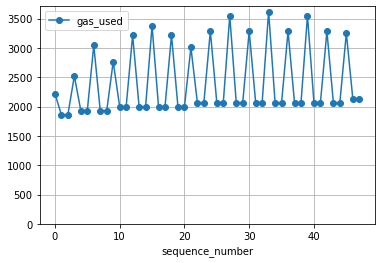

In [56]:
df = pd.DataFrame(gas)
ax = df.plot(x='sequence_number',
             y='gas_used',
             grid=True,
             style='-o')
ax.set_ylim(ymin=0);

Now remove each key-value pair:

In [57]:
# Fund from the faucet
faucet.fund_account(account.address().hex(), 1000000000)
gas2 = []
for i in range(n_insertions):
    # Get insertion key.
    insertion_key = int(i / 3)
    # Get access key.
    access_key = get_access_key(
        insertion_key + 1, i + 1, insertion_key)
    # Store tx JSON.
    tx_json = get_tx_json(remove(
        access_key, insertion_bits))
    # Assert successful tx.
    assert tx_json['success'] == True
    # Get gas used.
    gas_used = int(tx_json['gas_used'])
    # Log gas used.
    gas2.append({'sequence_number': i, 'gas_used': gas_used})
    # Print gas used.
    print(f'Count: {i}, gas used: {gas_used}')
    clear_output(wait=True) # Clear terminal output.

Count: 47, gas used: 1088


Here, costs are higher for each tree node that has to be removed, but otherwise constant:

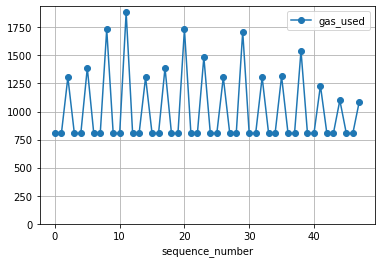

In [58]:
df2 = pd.DataFrame(gas2)
ax2 = df2.plot(x='sequence_number',
               y='gas_used',
               grid=True,
               style='-o')
ax2.set_ylim(ymin=0);

Insert again with allocated nodes:

In [62]:
# Fund from the faucet.
faucet.fund_account(account.address().hex(), 1000000000)
# Get number of tree nodes.
n_tree_nodes = int(n_insertions / 3)
# Reset, allocating nodes.
gas_diagnostics(get_tx_json(reset(
    n_tree_nodes, n_insertions)))
gas3 = []
for i in range(n_insertions):
    # Get insertion key.
    insertion_key = int(i / 3)
    # Get tree node ID.
    tree_node_id = n_tree_nodes - insertion_key
    # Get access key.
    access_key = get_access_key(
        tree_node_id, n_insertions - i, insertion_key)
    # Store tx JSON.
    tx_json = get_tx_json(insert(
        insertion_key, insertion_bits,
        access_key))
    # Assert successful tx.
    assert tx_json['success'] == True
    # Get gas used.
    gas_used = int(tx_json['gas_used'])
    # Log gas used.
    gas3.append({'sequence_number': i, 'gas_used': gas_used})
    # Print gas used.
    print(f'Count: {i}, gas used: {gas_used}')
    clear_output(wait=True) # Clear terminal output.

Count: 47, gas used: 1205


Here, costs are higher for each tree node that has to be inserted, but all costs are lower than for having to allocate a node each time:

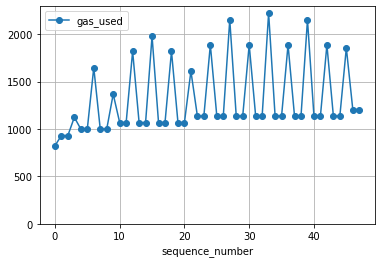

In [66]:
df3 = pd.DataFrame(gas3)
ax3 = df3.plot(x='sequence_number',
               y='gas_used',
               grid=True,
               style='-o')
ax3.set_ylim(ymin=0);